In [1]:
from convokit import Corpus, download

In [2]:
cons = Corpus(filename="/Users/yara/.convokit/downloads/subreddit-Conservative")
dems = Corpus(filename="/Users/yara/.convokit/downloads/subreddit-democrats")

In [3]:
cons.print_summary_stats()

Number of Speakers: 141593
Number of Utterances: 3078505
Number of Conversations: 306539


In [4]:
dems.print_summary_stats()

Number of Speakers: 37426
Number of Utterances: 369011
Number of Conversations: 84228


### Clean the data

In [5]:
def check_utts(corpus, convo):
    utts = convo.get_utterance_ids()
    for i in range(len(utts)):
        try:
            utt = corpus.get_utterance(utts[i])
            if utt.reply_to is not None:
                corpus.get_utterance(utt.reply_to)
        except:
            return False
    return True

In [6]:
cons_filtered = cons.filter_conversations_by(lambda x: check_utts(cons, x))

In [7]:
cons.print_summary_stats()

Number of Speakers: 141578
Number of Utterances: 3077820
Number of Conversations: 306513


In [8]:
dems_filtered = dems.filter_conversations_by(lambda x: check_utts(dems, x))

In [9]:
dems_filtered.print_summary_stats()

Number of Speakers: 37426
Number of Utterances: 368926
Number of Conversations: 84226


### Add Metadata

In [10]:
both = [spkr for spkr in dems_filtered.speakers if spkr in cons_filtered.speakers]

In [11]:
both.pop(0)

'[deleted]'

In [12]:
len(both)

9134

In [92]:
for spkr in both:
    cons_spkr = cons_filtered.get_speaker(spkr)
    dems_spkr = dems_filtered.get_speaker(spkr)
    cons_sprk_convo_n = len([convo for convo in cons_spkr.iter_conversations()])
    dems_sprk_convo_n = len([convo for convo in dems_spkr.iter_conversations()])

    cons_spkr.meta["con_convos"] = cons_sprk_convo_n
    cons_spkr.meta["dem_convos"] = dems_sprk_convo_n
    dems_spkr.meta["con_convos"] = cons_sprk_convo_n
    dems_spkr.meta["dem_convos"] = dems_sprk_convo_n

    cons_sprk_utt_n = len([utt for utt in cons_spkr.iter_utterances()])
    dems_sprk_utt_n = len([utt for utt in dems_spkr.iter_utterances()])

    cons_spkr.meta["con_utts"] = cons_sprk_utt_n
    cons_spkr.meta["dem_utts"] = dems_sprk_utt_n
    dems_spkr.meta["con_utts"] = cons_sprk_utt_n
    dems_spkr.meta["dem_utts"] = dems_sprk_utt_n

    cons_spkr.meta["main"] = True if cons_sprk_convo_n > dems_sprk_convo_n else False
    cons_spkr.meta["equal"] = True if cons_sprk_convo_n == dems_sprk_convo_n else False
    dems_spkr.meta["main"] = True if dems_sprk_convo_n > cons_sprk_convo_n else False
    dems_spkr.meta["equal"] = True if cons_sprk_convo_n == dems_sprk_convo_n else False

cons_main = [ spkr for spkr in both if cons_filtered.get_speaker(spkr).meta["main"] ] 
dems_main = [ spkr for spkr in both if dems_filtered.get_speaker(spkr).meta["main"] ] 

In [14]:
dems_filtered.dump(name="dems_filtered", base_path=os.getcwd()+'/data/processed/')
cons_filtered.dump(name="cons_filtered", base_path=os.getcwd()+'/data/processed/')

### Calculate coordination scores

In [15]:
from convokit import Coordination
import numpy as np

In [16]:
concoord = Coordination()
concoord.fit(cons_filtered)
concoord.transform(cons_filtered);

In [17]:
demcoord = Coordination()
demcoord.fit(dems_filtered)
demcoord.transform(dems_filtered);

In [18]:
everyone = lambda spkr: True
conservatives  = lambda spkr: spkr.id in cons_main 
democrats = lambda spkr: spkr.id in dems_main

In [19]:
import seaborn as sns, matplotlib.pyplot as plt
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 'figure.figsize':(16,9)}
sns.set_theme(style="ticks", font_scale=1.2, rc=custom_params)

In [ ]:
conservatives_to_all_conservatives = concoord.summarize(cons_filtered, conservatives, everyone)
conservatives_to_all_conservatives_scores = [ [spkr.id, score] for spkr, score in conservatives_to_all_conservatives.averages_by_speaker().items()]

conservatives_to_all_democrats = demcoord.summarize(dems_filtered, conservatives, everyone)
conservatives_to_all_democrats_scores = [ [spkr.id, score] for spkr, score in conservatives_to_all_democrats.averages_by_speaker().items()]

democrats_to_all_democrats = demcoord.summarize(dems_filtered, democrats, everyone)
democrats_to_all_democrats_scores = [ [spkr.id, score] for spkr, score in democrats_to_all_democrats.averages_by_speaker().items()]

democrats_to_all_conservatives = concoord.summarize(cons_filtered, democrats, everyone)
democrats_to_all_conservatives_scores = [ [spkr.id, score] for spkr, score in democrats_to_all_conservatives.averages_by_speaker().items()]

In [68]:
from scipy.stats import ttest_rel
import pandas as pd

cS = pd.DataFrame(conservatives_to_all_conservatives_scores)
cS.columns = ["speaker","conservative"]

cSd = pd.DataFrame(conservatives_to_all_democrats_scores)
cSd.columns = ["speaker","democrat"]

cS_cons = cSd.merge(cS, on ="speaker")

In [71]:
ttest_rel(cS_cons.conservative, cS_cons.democrat, alternative='greater')

Ttest_relResult(statistic=2.589778372688268, pvalue=0.004894067128607459)

In [76]:
dS = pd.DataFrame(democrats_to_all_democrats_scores)
dS.columns = ["speaker","democrat"]

dSc = pd.DataFrame(democrats_to_all_conservatives_scores)
dSc.columns = ["speaker","conservative"]

cS_dems = dSc.merge(dS, on ="speaker")

In [91]:
ttest_rel(cS_dems.democrat, cS_dems.conservative, alternative='greater')

Ttest_relResult(statistic=3.561291807833982, pvalue=0.0002008173358550846)

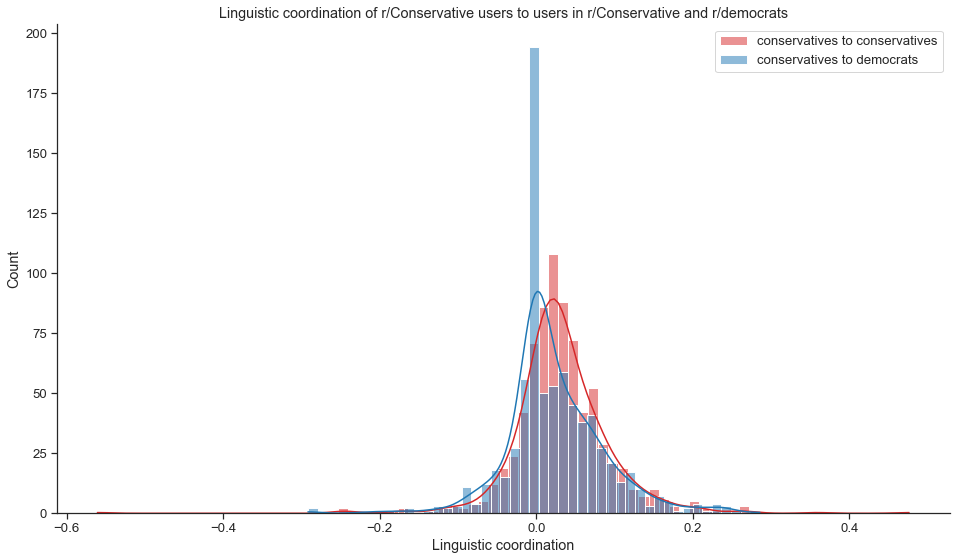

In [86]:
sns.histplot( cS_cons.conservative, label='conservatives to conservatives', kde=True, color = "#d62728");
sns.histplot( cS_cons.democrat, label='conservatives to democrats', kde=True, color = "#1f77b4");
plt.legend()
plt.title("Linguistic coordination of r/Conservative users to users in r/Conservative and r/democrats")
plt.xlabel("Linguistic coordination")
plt.show()

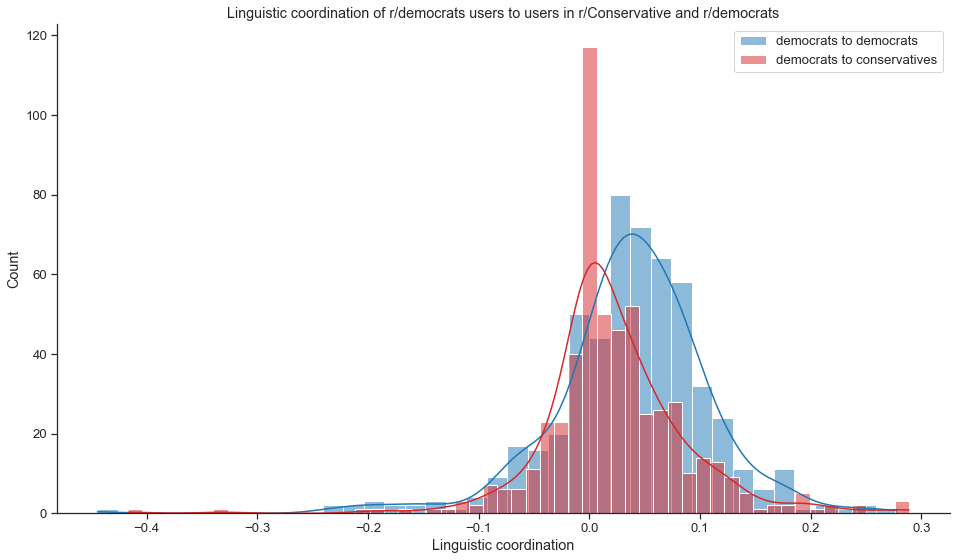

In [90]:
sns.histplot( cS_dems.democrat, label='democrats to democrats', kde=True, color =   "#1f77b4" );
sns.histplot( cS_dems.conservative, label='democrats to conservatives', kde=True, color = "#d62728");
plt.legend()
plt.title("Linguistic coordination of r/democrats users to users in r/Conservative and r/democrats")
plt.xlabel("Linguistic coordination")
plt.show()

### More in-depth linguistic coordination analysis 
code for make_chart function from "https://github.com/CornellNLP/ConvoKit/blob/master/examples/coordination/examples.ipynb"

In [ ]:

import matplotlib.patches as mpatches
def make_chart(a_scores, b_scores, a_description, b_description, a_color="b", b_color="g"):
    # get scores by marker and on aggregate
    a_score_by_marker = a_scores["marker_agg2"]
    a_agg1, a_agg2, a_agg3 = a_scores["agg1"], a_scores["agg2"], a_scores["agg3"]
    b_score_by_marker = b_scores["marker_agg2"]
    b_agg1, b_agg2, b_agg3 = b_scores["agg1"], b_scores["agg2"], b_scores["agg3"]

    # the rest plots this data as a double bar graph
    a_data_points = sorted(a_score_by_marker.items())
    b_data_points = sorted(b_score_by_marker.items())
    a_data_points, b_data_points = zip(*sorted(zip(a_data_points, b_data_points),
        key=lambda x: x[0][1], reverse=True))
    labels, a_data_points = zip(*a_data_points)
    _, b_data_points = zip(*b_data_points)

    labels = ["aggregate 1", "aggregate 2", "aggregate 3"] + list(labels)
    a_data_points = [a_agg1, a_agg2, a_agg3] + list(a_data_points)
    b_data_points = [b_agg1, b_agg2, b_agg3] + list(b_data_points)

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(a_data_points)) + 0.35)
    ax.set_xticklabels(labels, rotation="vertical")

    ax.bar(np.arange(len(a_data_points)), a_data_points, 0.35, color=a_color)
    ax.bar(np.arange(len(b_data_points)) + 0.35, b_data_points, 0.35, color=b_color)

    b_patch = mpatches.Patch(color="b",
                             label=a_description + " (total: " +
                             str(a_scores["count_agg1"]) + ", " +
                             str(a_scores["count_agg2"]) + ")")
    g_patch = mpatches.Patch(color="g",
                             label=b_description + " (total: "  +
                             str(b_scores["count_agg1"]) + ", " +
                             str(b_scores["count_agg2"]) + ")")
    plt.legend(handles=[b_patch, g_patch])

    filename = str(a_description) + " vs " + str(b_description) + ".png"
    plt.savefig(filename, bbox_inches="tight")
    print('Created chart "' + filename + '"')

Created chart "Conservative-coservative vs Conservative-democrat.png"


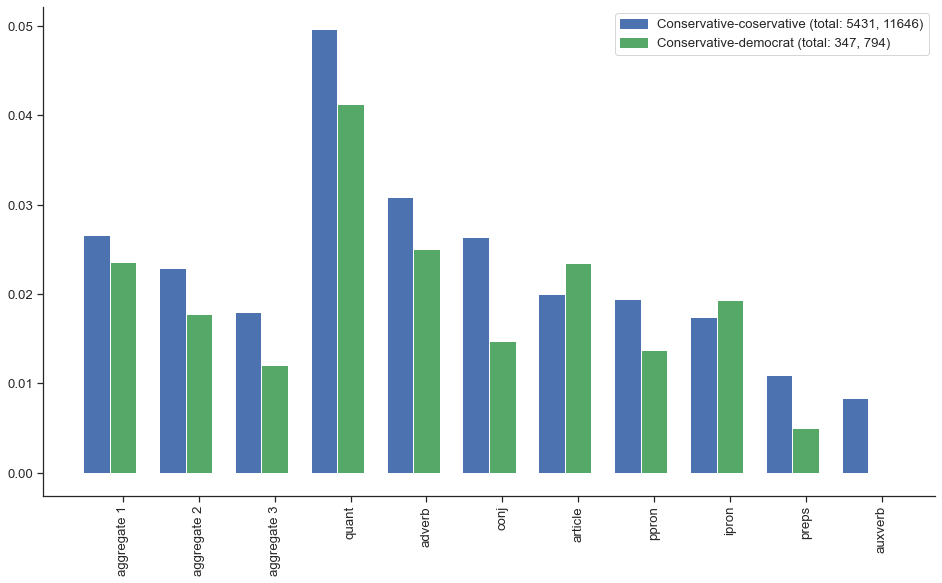

In [37]:
# do speakers on the whole coordinate more to admins or nonadmins?
make_chart(
    concoord.summarize(cons_filtered, conservatives, everyone,focus="targets", summary_report=True),
    demcoord.summarize(dems_filtered, conservatives, everyone,focus="targets", summary_report=True),
    "Conservative-coservative", "Conservative-democrat"
)

Created chart "Democrat-coservative vs Democrat-democrat.png"


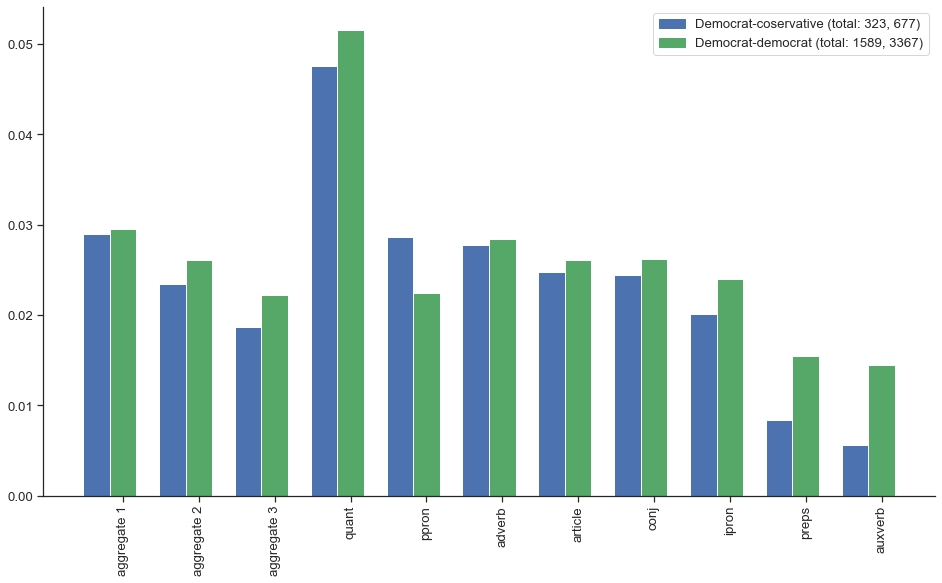

In [38]:
make_chart(
    concoord.summarize(cons_filtered, democrats, everyone,focus="targets", summary_report=True),
    demcoord.summarize(dems_filtered, democrats, everyone,focus="targets", summary_report=True),
    "Democrat-coservative", "Democrat-democrat"
)